In [4]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from tqdm import tqdm
DATA_ROOT = '../data/raw/YCup2021'
NUM_RECOMENDATIONS = 20
%matplotlib inline

### Сырые данные

### Считываем данные из .csv

Некоторые данные (такие как рубрики и признаки), представлены строками значений. Преобразуем их в списки чисел. 

In [5]:
to_list = lambda rubrics: [int(rubric) for rubric in str(rubrics).split(' ')]
def apply_to_columns(df, columns, func=to_list):
    for column in columns:
        df.loc[~df[column].isnull(), column] = df.loc[~df[column].isnull(), column].apply(func)

В первую очередь нам понадобятся данные по __пользователям__, __организациям__ и сами __отзывы__. 

In [6]:
users = pd.read_csv(DATA_ROOT + '/users.csv')
users.head()

,user_id,city
0,523295021912509756,msk
1,11952159487361099606,msk
2,16879036589969590999,msk
3,12791716990148606332,msk
4,11642393216024958726,msk


In [7]:
orgs = pd.read_csv(DATA_ROOT+'/organisations.csv')

# create lists
columns = ['rubrics_id', 'features_id']
apply_to_columns(orgs, columns)

orgs.head()

,org_id,city,average_bill,rating,rubrics_id,features_id
0,16848414477362211020,spb,1000.0,4.479702,"[30776, 31375]","[1018, 1509, 11177, 11617, 11629, 11704, 11867..."
1,1430604733320164116,spb,1000.0,4.514509,"[30776, 30770]","[246, 1018, 11617, 11629, 11704, 11867, 20422,..."
2,9880309324224147401,spb,1000.0,3.884615,"[30770, 30774]","[1018, 11177, 11617, 11629, 11704, 11867, 2042..."
3,5617879987171966456,spb,1000.0,NaN,"[30774, 30775]","[1018, 1509, 10596, 11177, 11629, 11634, 11704..."
4,5241461680470612149,spb,1000.0,4.532468,[30776],"[1018, 11177, 11617, 11629, 11704, 11867, 2042..."


Чтобы не делать __join__ каждый раз, когда нам потребуется узнать, из какого города организация или пользователь, сразу добавим эту информацию в отзывы.

In [8]:
reviews = pd.read_csv(DATA_ROOT+'/reviews.csv', low_memory=False)

# encode users ids as numeric
reviews = reviews.merge(users, on='user_id')
reviews = reviews.rename({'city': 'user_city'}, axis=1)

# # encode orgs ids as numeric
reviews = reviews.merge(orgs[['org_id', 'city']], on='org_id')
reviews = reviews.rename({'city': 'org_city'}, axis=1)

# # create lists
columns = ['aspects']
apply_to_columns(reviews, columns)

reviews.head()

,user_id,org_id,rating,ts,aspects,user_city,org_city
0,16998268288908323644,7184895086928047809,2.0,105,NaN,msk,msk
1,3121447338909258868,7184895086928047809,5.0,464,NaN,msk,msk
2,1970649778250883025,7184895086928047809,3.0,789,NaN,msk,msk
3,7554889464530643866,7184895086928047809,4.0,936,NaN,msk,msk
4,15907910894057053620,7184895086928047809,1.0,1143,NaN,msk,msk


### Парсим рубрики организаций

In [ ]:
from collections import defaultdict, Counter
RUBRICS_MAPPING = defaultdict(lambda : -1)
RUBRICS_MAPPING.update(
    {
        #1)
        30519:0, # Булочная, пекарня
        31495:0, # Кофейня
        31350:0, # Кондитерская
        3501750896:0, # Кофе с собой

        #2)
        30770:1, # "Бар, паб"
        31286:1, # Спортбар

        #3)
        30771:2, # Быстрое питание
        3501514558:2, # Фудкорт

        #4)
        30774:3, # Кафе

        #5)
        30775:4, # Пиццерия
        #6)
        30776:5, # Ресторан
        #7)
        30777:6, # Столовая

        #8)
        31375:7, # Суши-бар
        #9)
        31401:8, # Кальян-бар
        #10)
        3108292683:9, # Бар безалкогольных напитков
    }
)
def rubric_mapper(to_single_rubric=True):
    def remap_rubrics(rubric_ids):
        observed_rubrics = Counter((RUBRICS_MAPPING[rubric_id] for rubric_id in rubric_ids))
        if to_single_rubric:
            return observed_rubrics.most_common(1)[0][0]
        else:
            [rubric for rubric, count in observed_rubrics.most_common(3)]
    return remap_rubrics
RUBRIC_MAPPER = rubric_mapper()
orgs_filled_bill = orgs

orgs_filled_bill['rubric_id'] = orgs_filled_bill.rubrics_id.apply(RUBRIC_MAPPER)

### Заполняем пустые поля среднего чека

In [ ]:
reviews_at_home = train_reviews
reviews_at_home = reviews_at_home.merge(orgs, on='org_id', how='inner')[['user_id', 'average_bill']].dropna()
average_bill_for_user = reviews_at_home.groupby('user_id')['average_bill'].mean()

visits_vs_user_cash = train_reviews.merge(average_bill_for_user, on='user_id', how='inner')
visits_vs_user_cash = visits_vs_user_cash.groupby('org_id')['average_bill'].mean()

orgs_filled_bill = orgs.copy().merge(visits_vs_user_cash, on='org_id', how='left')

completed_bill = orgs_filled_bill['average_bill_x'].where(~orgs_filled_bill.average_bill_x.isna(), orgs_filled_bill.average_bill_y)
completed_bill.hist(log=True, bins=50)
completed_bill.quantile(0.95)
orgs_filled_bill['average_bill'] = completed_bill

### Сплит данных

In [10]:
from sklearn.model_selection import train_test_split
def train_val_split(reviews):
    reviews = reviews.sort_values('ts')
    # ts_split = 800
    # reviews_train, reviews_test = reviews[reviews.ts <  ts_split], reviews[reviews.ts >=  ts_split]   

    val_size = 0.20
    # reviews = reviews.sort_values('')
    reviews_train, reviews_test = train_test_split(reviews, test_size=val_size, shuffle=False)

    reviews_test = reviews_test[reviews_test.user_city != reviews_test.org_city]
    reviews_test = reviews_test[reviews_test.rating >= MIN_POSITIVE_RATE]

    train_users = set(reviews_train.user_id.unique())
    reviews_test = reviews_test[reviews_test.user_id.isin(train_users)]

    train_orgs = set(reviews_train.org_id.unique())
    reviews_test = reviews_test[reviews_test.org_id.isin(train_orgs)]

    return reviews_train, reviews_test
    
def extract_targets(reviews):
    y = reviews.groupby('user_id')['org_id'].apply(list).reset_index(name='target')
    x = pd.DataFrame(y['user_id'])
    return x,y


### Метрика

In [11]:
MIN_POSITIVE_RATE = 4.0
def MNAP(size):
    assert size >= 1, "Size must be greater, than zero!"
    def metric(y_true, predictions, size=size):
            y_true = y_true.rename({'target': 'y_true'}, axis='columns')
            predictions = predictions.rename({'target': 'predictions'}, axis='columns')
            merged = y_true.merge(predictions, left_on='user_id', right_on='user_id')

            def score(x):
                
                y_true = x.y_true
                predictions = x.predictions[:size]
                weight = 0
                
                inner_weights = [0]
                for n, item in enumerate(predictions):
                    inner_weight = inner_weights[-1] + (1 if item in y_true else 0)
                    inner_weights.append(inner_weight)
                
                for n, item in enumerate(predictions):                
                    if item in y_true:
                        weight += inner_weights[n + 1] / (n + 1)
                        
                return weight / min(len(y_true), size)
           
            return np.mean([score(row) for row in merged.iloc])
    return metric
MNAP_20 = MNAP(NUM_RECOMENDATIONS)



In [12]:
def MNAP(size=20):
    '''
    MNAP(size=20)
        Создаёт метрику под <size> сделанных предсказаний.
        
        Parameters
        ----------
        size : int, default=20
            Размер рекомендованной выборки для каждого пользователя
        
        Returns
        -------
        func(pd.DataFrame, pd.DataFrame) -> float
            Функция, вычисляющая MNAP.
        
    '''
    
    assert size >= 1, "Size must be greater than zero!"
    
    def metric(y_true, predictions, size=size):
        '''
        metric(y_true, predictions, size=size)
            Метрика MNAP для двух перемешанных наборов <y_true> и <y_pred>.
            
            Parameters
            ----------
            y_true : pd.DataFrame
                DataFrame с колонками <user_id> и <target>. 
                В <target> содержится список настоящих org_id, посещённых пользователем. 
                
            predictions : pd.DataFrame
                DataFrame с колонками <user_id> и <target>. 
                В <target> содержится список рекомендованных для пользователя org_id.
                
            Returns
            -------
            float 
                Значение метрики.
        '''
        
        y_true = y_true.rename({'target': 'y_true'}, axis='columns')
        predictions = predictions.rename({'target': 'predictions'}, axis='columns')
        
        merged = y_true.merge(predictions, left_on='user_id', right_on='user_id')
    
        def score(x, size=size):
            '''
            Вспомогательная функция.
            '''            
            y_true = x[1][1]
            predictions = x[1][2][:size]
            
            weight = 0
            
            inner_weights = [0]
            for n, item in enumerate(predictions):
                inner_weight = inner_weights[-1] + (1 if item in y_true else 0)
                inner_weights.append(inner_weight)
            
            for n, item in enumerate(predictions):                
                if item in y_true:
                    weight += inner_weights[n + 1] / (n + 1)
                    
            return weight / min(len(y_true), size)
    
        return np.mean([score(row) for row in merged.iterrows()])
    
        
    return metric


def print_score(score):
    print(f"Score: {score*100.0:.2f}")
    
    
N = 20
MNAP_N = MNAP(N)

###  Исследование распределения данных

#### Посмотрим на распределение новых отзывов по дням, чтобы понять, как лучше организовать валидацию. 




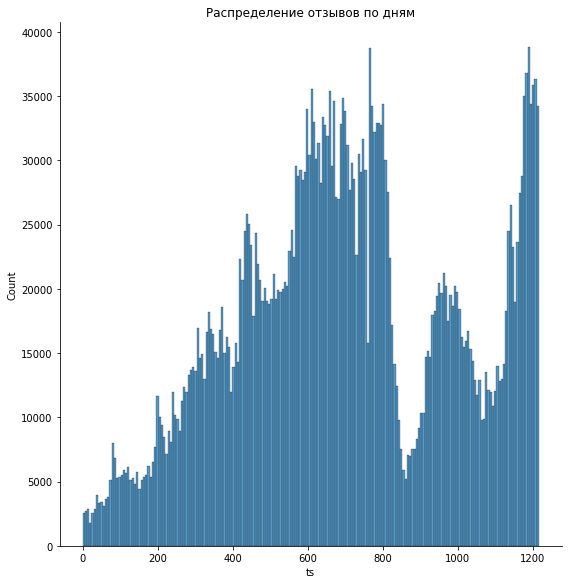

In [9]:
sns.displot(data=reviews, x='ts', height=8)
plt.title('Распределение отзывов по дням')
plt.show()

#### Все типы заведений, кроме безалкогольных баров распространены приблизительно одинаково

<AxesSubplot:>

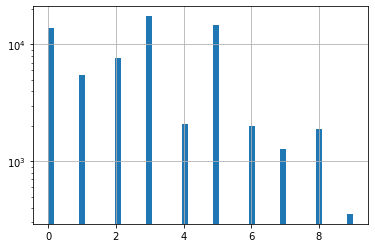

In [273]:
orgs_filled_bill['rubric_id'].hist(log=True, bins=50)

In [274]:
orgs_prep = orgs_filled_bill

#### Больша часть пользователей оставила только 1-2 отзыва. Это значит, что им не посоветовать ничего конкретного. Остается работать с пользователями у которых 5 и больше отызвов. Таких 142 000

142946


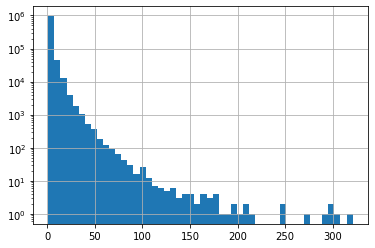

In [212]:
reviews_at_home = train_reviews[(train_reviews['org_city'] == train_reviews['user_city'])]

reviews_at_home = reviews_at_home.groupby('user_id')['org_id'].count()#.sort_values(ascending=False).head(15)
reviews_at_home.hist(log=True, bins=50)
print(len(reviews_at_home[reviews_at_home>=5].dropna()))

3500.0


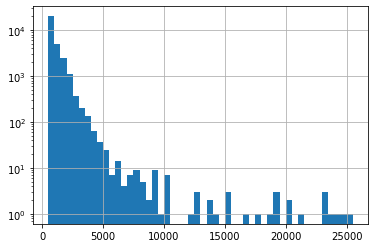

In [213]:
reviews_at_home = train_reviews#[(train_reviews['org_city'] == train_reviews['user_city'])]
reviews_at_home = reviews_at_home.merge(orgs, on='org_id', how='inner')[['org_id', 'average_bill']].dropna()
reviews_at_home = reviews_at_home.groupby('org_id')['average_bill'].max()#.sort_values(ascending=False).head(15)
reviews_at_home = reviews_at_home[reviews_at_home<=reviews_at_home.quantile(0.999)]
reviews_at_home.hist(log=True, bins=50)
print(reviews_at_home.quantile(0.99))

#### 99% чеков - до 3500 руб

<AxesSubplot:>

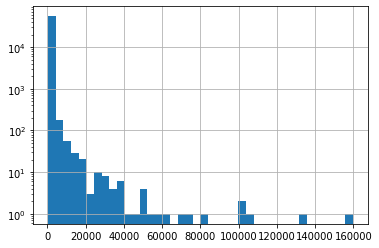

In [101]:
reviews_at_home = train_reviews#[(train_reviews['org_city'] == train_reviews['user_city'])]
reviews_at_home = reviews_at_home.merge(orgs, on='org_id', how='inner')[['user_id', 'average_bill']].dropna()
average_bill_for_user = reviews_at_home.groupby('user_id')['average_bill'].mean()#.sort_values(ascending=False).head(15)
# reviews_at_home = reviews_at_home[reviews_at_home<=reviews_at_home.quantile(0.999)]
# average_bill_for_user.hist(log=True, bins=50)
visits_vs_user_cash = train_reviews.merge(average_bill_for_user, on='user_id', how='inner')
visits_vs_user_cash = visits_vs_user_cash.groupby('org_id')['average_bill'].mean()
visits_vs_user_cash.hist(log=True, bins=40)


#### Распределение организаций по среднему чеку
Большая часть орагнизаций работают с чеком до 5k

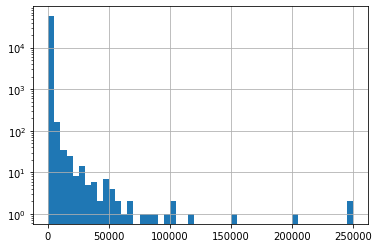

In [215]:
orgs_filled_bill = orgs.copy().merge(visits_vs_user_cash, on='org_id', how='left')
# bill_col = orgs_filled_bill['average_bill']
completed_bill = orgs_filled_bill['average_bill_x'].where(~orgs_filled_bill.average_bill_x.isna(), orgs_filled_bill.average_bill_y)
completed_bill.hist(log=True, bins=50)
completed_bill.quantile(0.95)
orgs_filled_bill['average_bill'] = completed_bill

#### Распределение юзов по количеству отзывов
У 80% юзов до 3х отзывов. Это значит, что 80% пользователей можно советовать только по массовой статистике.
И массовые отзывы можно использовать для накопления инфы и рекомендаций заведений тем, кто оставляет больше отзывов и инфы о себе

3.0


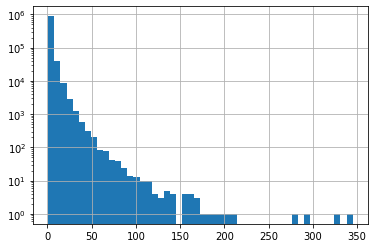

In [220]:
best_reviews_at_home = train_reviews[(train_reviews['rating'] >= 4) & (train_reviews['org_city'] == train_reviews['user_city'])]
best_reviews_at_home = best_reviews_at_home.merge(orgs, on='org_id', how='inner')

best_reviews_at_home['rubric_id'] = best_reviews_at_home['rubrics_id'].apply(rubric_mapper_to_single)
best_reviews_by_user = best_reviews_at_home.groupby('user_id')['org_id'].count()#.sort_values(ascending=False).head(15)
best_reviews_by_user.hist(log=True, bins=50)
print(best_reviews_by_user.quantile(0.80))

#### Ищу временные зависимости в данных. Средний чек зависит от дня недели, но это слишком большое усреднение

<AxesSubplot:xlabel='ts'>

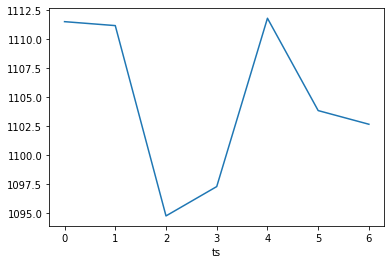

In [126]:
ts_vs_bill = train_reviews.merge(orgs_filled_bill, on='org_id', how='inner')[['ts', 'average_bill']]
ts_vs_bill['ts'] = ts_vs_bill['ts']%7
ts_vs_bill.groupby('ts')['average_bill'].mean().plot()

#### распределение отрицательных отзывов по юзам
отрицательных отзывов меньше положительных

2.0


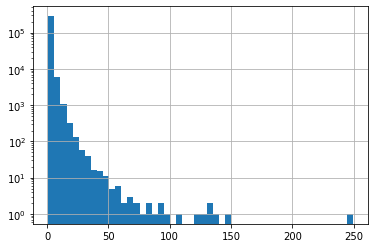

In [478]:
worst_reviews_at_home = train_reviews[(train_reviews['rating'] < 4) & (train_reviews['org_city'] == train_reviews['user_city'])]
worst_reviews_at_home = worst_reviews_at_home.merge(orgs, on='org_id', how='inner')

worst_reviews_at_home['rubric_id'] = worst_reviews_at_home['rubrics_id'].apply(rubric_mapper_to_single)
worst_reviews_at_home = worst_reviews_at_home.groupby('user_id')['org_id'].count()#.sort_values(ascending=False).head(15)
worst_reviews_at_home.hist(log=True, bins=50)
print(worst_reviews_at_home.quantile(0.8))

### Подбор периода, по которому лучше всего считать рейтинги
Получилось, что наилучшая метрика достигается при обучении за период в 365*0.65 = 237 дней (7-8 месяцев)


По этим признакам подобрать в новом городе заведения с наибольшим числом общих признаков. Взять топ-10 
по среднему рейтингу, взять еще топ-10 других заведений по общему рейтингу. Создать топ-20 попеременно чередуя заведения из двух рейтингов







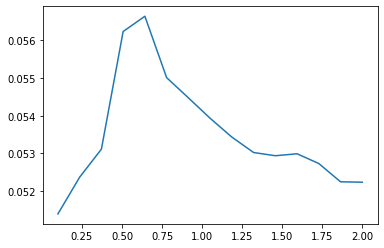

In [460]:
# orgs_filled_bill
data_observation_length = np.linspace(0.1,2,num=15)
metric_per_period = np.zeros(data_observation_length.shape)
for i, length in enumerate(data_observation_length):
    popular_recomends = BillRangeRecomender()
    popular_recomends.fit(train_reviews[train_reviews['ts'].max()-train_reviews['ts'] <365*length])

    target = popular_recomends.predict(X_val)

    predictions = X_val.copy()
    predictions['target'] = target
    score = MNAP_20(y_val, predictions)
    metric_per_period[i] = score
    # print_score()
plt.plot(data_observation_length, metric_per_period)
data_observation_length[metric_per_period.argmax()], metric_per_period.max()

### Смотрим метрику лучшей модели на холодных и горячих юзах
На холодных юзах метрика выше, чем на горячих при разбивке по любому числу отзывов

In [442]:
popular_recomends = BillRangeRecomender()
popular_recomends.fit(train_reviews)


rare_test_users = test_user_freq[test_user_freq <= 10]
rare_x_val = X_val.set_index('user_id').loc[rare_test_users.index]
rare_y_val = y_val.set_index('user_id').loc[rare_test_users.index]
target = popular_recomends.predict(rare_x_val)

predictions = rare_x_val.copy()
predictions['target'] = target

print_score(MNAP_20(rare_y_val, predictions))

Score: 5.41


In [472]:
popular_recomends = MostVisitedTouristRecomender()
popular_recomends.fit(train_reviews[train_reviews['ts'].max()-train_reviews['ts'] <365*0.5])

frequent_test_users = test_user_freq[test_user_freq > 10]
frequent_x_val = X_val.set_index('user_id').loc[frequent_test_users.index]
frequent_y_val = y_val.set_index('user_id').loc[frequent_test_users.index]
target = popular_recomends.predict(frequent_x_val)

predictions = frequent_x_val.copy()
predictions['target'] = target

print_score(MNAP_20(frequent_y_val, predictions))

Score: 5.50


## Классификаторы

### Выбрать заведение с наибольшим числом отзывов среди туристов (ТОП)

In [84]:
class MostVisitedTouristRecomender(Recomender):
    def fit(self, x_train, y_train=None, num_recomendations=NUM_RECOMENDATIONS):
        self._num_recomendations = num_recomendations

        msk_orgs = x_train[(x_train['rating'] >= 4) & (x_train['org_city'] == 'msk') & (x_train['user_city'] == 'spb')]['org_id']
        msk_orgs = msk_orgs.value_counts().index[:self._num_recomendations].to_list()

        spb_orgs = x_train[(x_train['rating'] >= 4) & (x_train['org_city'] == 'spb') & (x_train['user_city'] == 'msk')]['org_id']
        spb_orgs = spb_orgs.value_counts().index[:self._num_recomendations].to_list()
        
        self._other_city_orgs = {'msk': spb_orgs, 'spb' : msk_orgs}
    def select_best_orgs(self, review_orgs):
        best_orgs = review_orgs.value_counts().index[:self._num_recomendations].to_list()
        return best_orgs
    def _predict_single(self, user):
        recomended_orgs = self._other_city_orgs[user.city]
        return recomended_orgs

#### Пока что этот метод дает самую высокую метрику

In [85]:
popular_recomends = MostVisitedTouristRecomender()
popular_recomends.fit(train_reviews)

target = popular_recomends.predict(X_val)

predictions = X_val.copy()
predictions['target'] = target

print_score(MNAP_20(y_val, predictions))

Score: 5.21


### Первый подход - случайная рекомендация, отработка пайплайна


In [13]:
class Recomender:
    def __init__(self):
        pass
    
    def predict(self, users_pred):
        """randomly predict places for every user in the DataFram

        Args:
            users_pred (pd.DataFrame): DataFrame of one column 'user_id'

        Raises:
            ValueError: the function accepts only DataFrames

        Returns:
            pd.DataFrame: DataFrame of 2 columns: 'user_id', 'target'
        """
        if not isinstance(users_pred, pd.DataFrame):
            raise ValueError('Classifier accepts only pd.DataFrame as x_pred, but got {:}'.format(str(type(users_pred))))
        # val_target_pred = []
        

        val_target_pred = users_pred.apply(lambda x: self._predict_single(x), axis=1)
        
        val_target_pred.name = 'target'
        val_target_pred = pd.DataFrame(val_target_pred)
        return val_target_pred


In [14]:
test_users = pd.read_csv(DATA_ROOT + '/test_users.csv')
test_users_with_locations = test_users.merge(users, on='user_id', how='left')
key_columns = ['user_id']

train_reviews, test_reviews = train_val_split(reviews)

X_val, y_val = extract_targets(test_reviews)
X_val = X_val.merge(users, on='user_id', how='left')
train_reviews.shape, test_reviews.shape

((2912668, 7), (15859, 7))

In [15]:
class RandomRecomender(Recomender):
    def fit(self, x_train, y_train=None, num_recomendations=NUM_RECOMENDATIONS):
        org_ids = pd.DataFrame(x_train['org_id'])
        _orgs = org_ids.merge(orgs, on='org_id', how='left')
        self._num_recomendations = num_recomendations
        self._other_city_orgs = {city:_orgs[_orgs.city != city] for city in _orgs.city.unique()}

    def _predict_single(self, user):
        recomended_orgs = np.random.choice(self._other_city_orgs[user.city]['org_id'], self._num_recomendations)
        return recomended_orgs

### Random recomendations

In [16]:
num_users_process = -1
random_recomendation = RandomRecomender()
random_recomendation.fit(train_reviews)

target = random_recomendation.predict(X_val)
predictions = X_val.copy()
predictions['target'] = target
mnap_test = MNAP_20(y_val, predictions)

print('MNAP@20 test = {:.3f}'.format(mnap_test*100))


MNAP@20 test = 0.709


### Выбрать заведение с самым большим числом позитивных отзывов

In [462]:
class MostVisitedRecomender(Recomender):
    def fit(self, x_train, y_train=None, num_recomendations=NUM_RECOMENDATIONS):
        self._num_recomendations = num_recomendations
        
        msk_orgs = x_train[(x_train['rating'] >= 4) & (x_train['org_city'] == 'msk')]['org_id']
        msk_orgs = msk_orgs.value_counts().index[:N].to_list()

        spb_orgs = x_train[(x_train['rating'] >= 4) & (x_train['org_city'] == 'spb')]['org_id']
        spb_orgs = spb_orgs.value_counts().index[:N].to_list()
        
        self._other_city_orgs = {'msk': spb_orgs, 'spb' : msk_orgs}
    def select_best_orgs(self, review_orgs):
        best_orgs = review_orgs.value_counts().index[:self._num_recomendations].to_list()
        return best_orgs
    def _predict_single(self, user):
        recomended_orgs = self._other_city_orgs[user.city]
        return recomended_orgs

In [466]:
popular_recomends = MostVisitedRecomender()
popular_recomends.fit(train_reviews)

target = popular_recomends.predict(X_val)

predictions = X_val.copy()
predictions['target'] = target

print_score(MNAP_20(y_val, predictions))


Score: 3.18


### Классификатор, усредняющий ретинг заведения по среднему рейтингу в выборке: 
заведения с средним и низким числом голосов получают среднестатистический рейтинг, чем больше голосов - тем ближе рейтинг к собственному неустредненному рейтингу

In [19]:
class WeightedVoter:
    def __init__(self, min_votes, average_vote):
        self.min_votes = min_votes
        self.averate_vote = average_vote
    def __call__(self, row):
        votes_sum = row.vote_count + self.min_votes
        movie_part = row.vote_count * row.vote_average
        average_part = self.min_votes * self.averate_vote
        return  (movie_part + average_part) / votes_sum


class WeightedPopularRecomender(Recomender):
    rates_from_allowed = ['all']
    def __init__(self, rates_from='all', quantile=0.95, num_recomendations=NUM_RECOMENDATIONS):
        if rates_from not in self.rates_from_allowed:
            raise ValueError('Ratings can be collected from {:}, but {} is passed'.format(self.rates_from_allowed, rates_from))
        self.rates_from = rates_from
        self._num_recomendations = num_recomendations
        self.quantile = quantile
    def calculate_weighted_rate(self, x_train, quantile_to_participate):
        #     [] -> []
        #     [(0,0)] -> []
        #     
        rate_col_name = 'weighted_rating'
        movies_for_rate = x_train[['vote_count', 'vote_average']].copy().dropna()
        mean_vote = 0
        total_votes = movies_for_rate['vote_count'].sum()
        if total_votes > 0:
            mean_vote = np.sum(movies_for_rate['vote_count'] * movies_for_rate['vote_average']) / total_votes
        
        min_votes_to_participate = movies_for_rate['vote_count'].quantile(quantile_to_participate)
        min_votes_to_participate = max(1, min_votes_to_participate)
        weighted_voter = WeightedVoter(min_votes_to_participate, mean_vote)
        featured_movies = movies_for_rate[movies_for_rate['vote_count'] >= min_votes_to_participate]
        wr = featured_movies.apply(weighted_voter, axis=1)
        wr.name = rate_col_name
        qualified = x_train.merge(wr, how='right', left_index=True, right_index=True)
        if len(wr) > 0:
            qualified = qualified.sort_values(rate_col_name, ascending=False)        
        return qualified
    def select_topk_orgs(self, org_rates, topk):
        topk_orgs = org_rates.sort_values('vote_count', ascending=False).iloc[:topk]
        return topk_orgs
    def fit(self, x_train:pd.DataFrame, y_train=None):
        grpby_org_id = x_train.groupby('org_id')
        vote_average = grpby_org_id['rating'].mean()
        vote_average.name = 'vote_average'
        vote_count = grpby_org_id['rating'].count()
        vote_count.name = 'vote_count'
        org_rates = orgs.merge(vote_count,on='org_id', how='inner').merge(vote_average,on='org_id')
        _org_weighted_rates = self.calculate_weighted_rate(org_rates, self.quantile)
        
        self._other_city_orgs = {city: self.select_topk_orgs(_org_weighted_rates[_org_weighted_rates.city != city], self._num_recomendations) for city in _org_weighted_rates.city.unique()}
        

    def _predict_single(self, user):
        different_city_orgs = self._other_city_orgs[user.city]
        recomended_orgs = different_city_orgs['org_id'].to_list()
        return recomended_orgs


#### По взвешенному рейтингу метрика не сильно увеличилась

In [477]:
popular_recomends = WeightedPopularRecomender(quantile=0.1)
popular_recomends.fit(train_reviews)

target = popular_recomends.predict(X_val)

predictions = X_val.copy()
predictions['target'] = target

print_score(MNAP_20(y_val, predictions))

Score: 3.04


### Выбрать рестораны похожие на те, что высоко оценил турист в своем родном городе
Выбрать отзывы туриста с оценкой >= 4 в родном городе, у заведения взять его тип.
Для каждого пользователя упорядочить каждый тип ресторана по количеству положительных отзывов.
Мб что какой-то тип ресторанов для юза просто неизвестен.
Получится многорукий бандит по типу ресторанов.




### Классификатор, использующий для рекомендаций только отзывы с заданным диапазоном суммы чека

In [112]:
class BillRangeRecomender(Recomender):
    def __init__(self, min_bill=500, max_bill=50000):
        super().__init__()
        self.min_bill = min_bill
        self.max_bill = max_bill
    def fit(self, x_train, y_train=None, num_recomendations=NUM_RECOMENDATIONS):
        self._num_recomendations = num_recomendations
        
        x_train = self._fill_bill(x_train)
        # print(x_train)
        org_features = 'org_id'.split()

        msk_orgs = x_train[(x_train['rating'] >= 4) & (x_train['org_city'] == 'msk') & (x_train['user_city'] == 'spb') & (x_train['average_bill'] >= self.min_bill)& (x_train['average_bill'] <= self.max_bill)]['org_id']
        msk_orgs = msk_orgs.value_counts().index[:self._num_recomendations].to_list()

        spb_orgs = x_train[(x_train['rating'] >= 4) & (x_train['org_city'] == 'spb') & (x_train['user_city'] == 'msk') & (x_train['average_bill'] >= self.min_bill)& (x_train['average_bill'] <= self.max_bill)]['org_id']
        spb_orgs = spb_orgs.value_counts().index[:self._num_recomendations].to_list()
        
        self._other_city_orgs = {'msk': spb_orgs, 'spb' : msk_orgs}
    def _fill_bill(self, x_train):
        
        reviews_at_home = x_train.merge(orgs, on='org_id', how='inner')[['user_id', 'average_bill']].dropna()
        average_bill_for_user = reviews_at_home.groupby('user_id')['average_bill'].mean()
        # self.user_money = average_bill_for_user.set_index('user_id')

        visits_vs_user_cash = x_train.merge(average_bill_for_user, on='user_id', how='inner')
        visits_vs_user_cash = visits_vs_user_cash.groupby('org_id')['average_bill'].mean()
        
        orgs_filled_bill = orgs.copy().merge(visits_vs_user_cash, on='org_id', how='left')
        
        completed_bill = orgs_filled_bill['average_bill_x'].where(~orgs_filled_bill.average_bill_x.isna(), orgs_filled_bill.average_bill_y)
        
        orgs_filled_bill['average_bill'] = completed_bill
        return x_train.merge(orgs_filled_bill[['org_id', 'average_bill']], on='org_id', how='inner')

    def select_best_orgs(self, review_orgs):
        best_orgs = review_orgs.value_counts().index[:self._num_recomendations].to_list()
        return best_orgs
    def _predict_single(self, user):
        recomended_orgs = self._other_city_orgs[user.city]
        return recomended_orgs

### Классификатор, отдельно подбирающий рекомендации для холодных и горячих юзов. Холодным - общие топы, горячим - топ по любимым рубрикам
Топ по рубрикам сделан криво - рекомендации идут только по одной рубрике, поэтому отклика мало

In [393]:
def fill_bill(reviews, orgs):
    
    user_bills = reviews.merge(orgs, on='org_id', how='inner')[['user_id', 'average_bill']].dropna()
    average_bill_for_user = user_bills.groupby('user_id')['average_bill'].mean()
    # self.user_money = average_bill_for_user.set_index('user_id')

    visits_vs_user_cash = reviews.merge(average_bill_for_user, on='user_id', how='inner')
    visits_vs_user_cash = visits_vs_user_cash.groupby('org_id')['average_bill'].mean()
    
    orgs_filled_bill = orgs.copy().merge(visits_vs_user_cash, on='org_id', how='left')
    
    completed_bill = orgs_filled_bill['average_bill_x'].where(~orgs_filled_bill.average_bill_x.isna(), orgs_filled_bill.average_bill_y)
    orgs_filled_bill.drop('average_bill_x', axis=1)
    orgs_filled_bill.drop('average_bill_y', axis=1)
    orgs_filled_bill['average_bill'] = completed_bill
    return orgs_filled_bill
def fill_rubric_id(orgs):
    RUBRIC_MAPPER
    orgs_filled_bill['rubric_id'] = orgs_filled_bill.rubrics_id.apply(RUBRIC_MAPPER)
def select_topk_by_index(index, index_level=0, topk=3):
    prev_index = -1
    topk_counter = 0
    for index_pair in index:
        index_value = index_pair[index_level]
        if index_value != prev_index:
            topk_counter = 1
        else:
            topk_counter += 1
        if topk_counter <= topk:
            yield index_pair
        prev_index = index_value

class SimilairTypeRecomender(Recomender):
    def __init__(self, min_reviews_to_personalize=5):
        super().__init__()
        self.min_reviews_to_personalize = min_reviews_to_personalize

    def fit(self, x_train, y_train=None, num_recomendations=NUM_RECOMENDATIONS):
        self._num_recomendations = num_recomendations
        
        self.num_visits_at_home = self._count_visits(x_train)
        self._x_train = x_train
        self._best_by_rubric = {}
        

        msk_orgs = x_train[(x_train['rating'] >= 4) & (x_train['org_city'] == 'msk') & (x_train['user_city'] == 'spb')]
        self._best_by_rubric['spb'] = self._get_best_by_rubric(msk_orgs, num_recomendations)
        msk_orgs = msk_orgs['org_id'].value_counts().index[:self._num_recomendations].to_list()

        spb_orgs = x_train[(x_train['rating'] >= 4) & (x_train['org_city'] == 'spb') & (x_train['user_city'] == 'msk')]
        self._best_by_rubric['msk'] = self._get_best_by_rubric(spb_orgs, num_recomendations)
        spb_orgs = spb_orgs['org_id'].value_counts().index[:self._num_recomendations].to_list()
        
        self._other_city_orgs = {'msk': spb_orgs, 'spb' : msk_orgs}
        
    def _count_visits(self, x_train):
        reviews_at_home = x_train[(x_train['org_city'] == x_train['user_city'])]

        reviews_at_home = reviews_at_home.groupby('user_id')['org_id'].count()

        return reviews_at_home
    def _get_best_by_rubric(self, x_train, topk):
        reviews_and_rubric = x_train.merge(orgs_filled_bill[['org_id', 'rubric_id']], on='org_id', how='inner')
        grouper = reviews_and_rubric.groupby(['rubric_id'])['org_id'].value_counts()
        new_index = pd.MultiIndex.from_tuples(list(select_topk_by_index(grouper.index, 0, topk)), names=['rubric_id', 'org_id'])
        most_frequent_orgs_by_rubric = orgs_filled_bill.set_index('org_id').loc[new_index.get_level_values(1)]
        return most_frequent_orgs_by_rubric

    def _predict_personal(self, user):

        reviews_by_user = self._x_train[(self._x_train.user_id == user.user_id)]
        reviews_by_user = reviews_by_user[reviews_by_user.rating >= 4]
        reviews_by_user = reviews_by_user[reviews_by_user.org_city == user.city].merge(orgs_filled_bill, on='org_id', how='inner')
        rubrics_by_rating = reviews_by_user['rubric_id'].value_counts()
        if len(rubrics_by_rating.index > 0):
            favorite_rubric = rubrics_by_rating.index[:3]
            best_by_rubric_in_city = self._best_by_rubric[user.city]
            personal_orgs = best_by_rubric_in_city[best_by_rubric_in_city.rubric_id.isin(favorite_rubric)]

            return personal_orgs
        else:
            return self._other_city_orgs[user.city]

    def _predict_single(self, user):
        popular_orgs = self._other_city_orgs[user.city]
        if user.user_id in self.num_visits_at_home.index and self.num_visits_at_home.loc[user.user_id] < self.min_reviews_to_personalize:
            recomended_orgs = popular_orgs
        else:
           pass 
           recomended_orgs = self._predict_personal(user)
           
        return recomended_orgs